In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from SALib.analyze import sobol


Sobol sensitivity analysis using saltelli sampling.
Using the results from run_sa.py.

Read the data

In [13]:
data_files = ["SA_Reactive_2019-02-06_20-27-24.csv", "SA_Reactive_2019-02-08_09-38-53.csv",
             "SA_Reactive_2019-02-07_12-30-52.csv", "SA_Reactive_2019-02-07_12-29-47.csv",
             "SA_Reactive_2019-02-07_11-35-48.csv", "SA_Reactive_2019-02-06_19-16-38.csv"]

read_files = [pd.read_csv(data_files[i]) for i in range(len(data_files))]
data = pd.concat(read_files, ignore_index=True, sort=False)
# normalize mean
data = data.assign(mean_norm=data['mean']/data['max_peds'])
data


,run,crossing_mean,max_peds,vision_range,stoch_variable,strategy,mean,mean_norm
0,0,0.331836,23.0,4.074219,0.206260,Reactive,0.0522,0.002270
1,1,0.368164,23.0,4.074219,0.206260,Reactive,0.0570,0.002478
2,2,0.331836,56.0,4.074219,0.206260,Reactive,0.0858,0.001532
3,3,0.331836,23.0,2.183594,0.206260,Reactive,0.0608,0.002643
4,4,0.331836,23.0,4.074219,0.270830,Reactive,0.0520,0.002261
5,5,0.331836,56.0,2.183594,0.270830,Reactive,0.0976,0.001743
6,6,0.368164,23.0,2.183594,0.270830,Reactive,0.0466,0.002026
7,7,0.368164,56.0,4.074219,0.270830,Reactive,0.0912,0.001629
8,8,0.368164,56.0,2.183594,0.206260,Reactive,0.0906,0.001618
9,9,0.368164,56.0,2.183594,0.270830,Reactive,0.0862,0.001539


Set the variables

In [14]:
data_names = ["mean"]
# parameter bounds
bounds = [[.2, .8], # crossing_mean
          [20,60], # max_peds
          [2,6],# vision range in meters
          [.01, .3]] # stoch var

# problem set
problem = {
    'num_vars': len(bounds),
    'names': ["crossing_mean", "max_peds", "vision_range",
        "stoch_variable"],
    'bounds': bounds
}

# Names for the labels
params = ["crossing mean", "max peds", "vision range",
        "stoch variable"]

In [15]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
        
    Code from assignments of course Agent-based modelling, january 2019
    """

    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        one, two = zip(*params)
        labels = [one[i]+'\n'+two[i] for i in range(len(one))]

        indices = s['S' + str(i)].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + str(i) + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
        
        params = labels
    else:
        indices = s['S' + str(i)]
        errors = s['S' + str(i) + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

C:\Users\linda\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


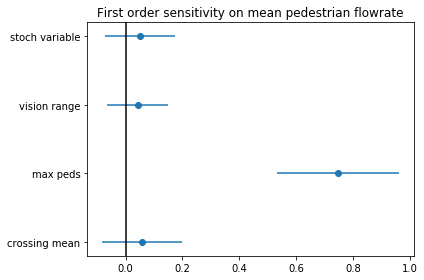

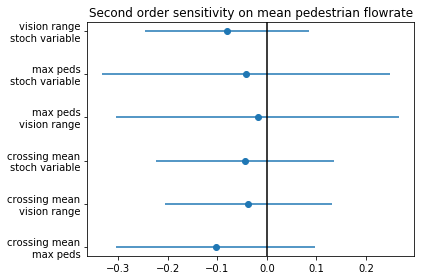

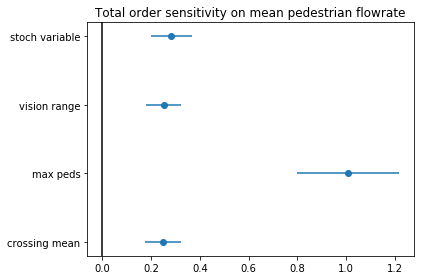

In [16]:
Si = sobol.analyze(problem, data[data_names[0]].as_matrix(), print_to_console=False)

# First order
plot_index(Si, params, '1', 'First order sensitivity on mean pedestrian flowrate')
plt.tight_layout()
plt.savefig("SA_first.png")
plt.show()

# Second order
plot_index(Si, params, '2', 'Second order sensitivity on mean pedestrian flowrate')
plt.tight_layout()
plt.savefig("SA_second.png")
plt.show()

# Total order
plot_index(Si, params, 'T', 'Total order sensitivity on mean pedestrian flowrate')
plt.tight_layout()
plt.savefig("SA_total.png")
plt.show()


Normalized results

In [19]:
data_names = ["mean_norm"]
# parameter bounds
bounds = [[.2, .8], # crossing_mean
          [20,60], # max_peds
          [2,6],# vision range in meters
          [.01, .3]] # stoch var

# problem set
problem = {
    'num_vars': len(bounds),
    'names': ["crossing_mean", "max_peds", "vision_range",
        "stoch_variable"],
    'bounds': bounds
}

# Names for the labels
params = ["crossing mean", "max peds", "vision range",
        "stoch variable"]

C:\Users\linda\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


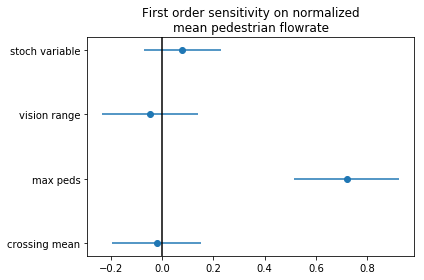

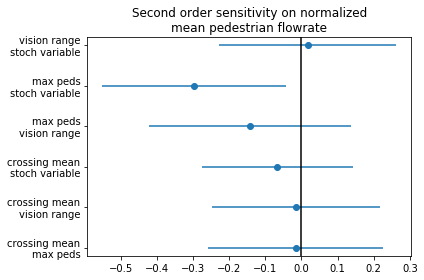

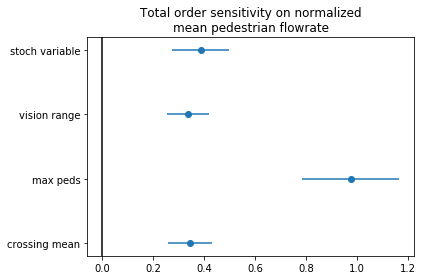

In [21]:
Si = sobol.analyze(problem, data[data_names[0]].as_matrix(), print_to_console=False)

# First order
plot_index(Si, params, '1', 'First order sensitivity on normalized\nmean pedestrian flowrate')
plt.tight_layout()
plt.savefig("SA_first_norm.png")
plt.show()

# Second order
plot_index(Si, params, '2', 'Second order sensitivity on normalized\nmean pedestrian flowrate')
plt.tight_layout()
plt.savefig("SA_second_norm.png")
plt.show()

# Total order
plot_index(Si, params, 'T', 'Total order sensitivity on normalized\nmean pedestrian flowrate')
plt.tight_layout()
plt.savefig("SA_total_norm.png")
plt.show()
